#Experiment - degrade knowledge of e and i params and see if we can still pick up K16. Conclusion - best case is around 0.15d per transit off, on average. Not a great deal of overlap with the real transits, but close enough to blur.

In [2]:
#can we find K16 while assuming basic values for the e and i parameters?
import copy
import numpy as np
import emcee
import corner
import matplotlib.pyplot as p
import astropy.units as u
import funcs

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
# Kepler 16
cb = funcs.CBSystem(m1 = 0.6897,f1 = 1.,m2 = 0.20255,f2 = 0.01555,
                    ab = 0.22431,r1 = 0.6489 * u.Rsun.to('au'),r2 = 0.22623 * u.Rsun.to('au'),
                    eb = 0.15944,ib = np.deg2rad(90.3401),wb = np.deg2rad(263.464),
                    fb = np.deg2rad(186.53239),
                    mp = .03e-3,ap = 0.7048,rp = 0.7538 * u.Rjupiter.to('au'),ep = 0.0069,
                    ip = np.deg2rad(90.0322),wp = np.deg2rad(318.0),fp = np.deg2rad(148.92),
                    Wp = np.deg2rad(0.003),
                    t0 = 2455212.12316)
ab0 = cb.ab
mb0 = cb.m1 + cb.m2
p_p0 = (cb.ap**3/(cb.m1+cb.m2))**(1./2.)*365.25 #in days
fp0 = np.deg2rad(148.92)
print(1/np.sqrt( (cb.m1+cb.m2)/cb.ab**3 )*365.25)
print(p_p0)

timing_precision = 30./86400./365.25 * (2*np.pi)  #in years/2pi
dt = 0.02
t = np.arange(2454953,2456424,dt)


41.0790034492
228.79461019691053


In [4]:
# make the reference stacked light curve set

#tts = funcs.reb_cb_c(cb,tmin=np.min(t),tmax=np.max(t))
tts = funcs.reb_cb(cb,tmin=np.min(t),tmax=np.max(t))
tts_2,tds_2 = funcs.reb_cb_dvm(cb,0,2,tmin=np.min(t),tmax=np.max(t), timing_precision=timing_precision)
    
ok = tts[:,0] == 20
#ref_tts = tts[ok]
ref_tts = tts_2[tds_2>0]
ref_tds = tds_2[tds_2>0]
print(ref_tts)

[ 2454973.42259501  2455203.69852041  2455425.21178602  2455655.48735769
  2455876.99743978  2456107.27318831  2456328.77336609]


In [89]:
#degrading our knowledge (assume we know eb and wb):
#for now, radii left as we know them - this will change transit durations, and whether some marginal transits happen.

cb.ib = np.pi/2.
cb.ip = np.pi/2.
cb.Wp = 0.0
cb.ep = 0.0
#cb.wp left as is because it defines f_p
cb.mp = 0.0



In [5]:
#now scan across m2/m1, m1+m2, p_p, f_p, as if we were searching.
mratset = np.linspace(cb.m2/cb.m1*0.9,cb.m2/cb.m1*1.1,21)
mtotset = np.linspace(cb.m2+cb.m1*0.9,cb.m1+cb.m2*1.1,5)
ppset = np.linspace(p_p0*0.97,p_p0*1.03,101)
fpset = np.linspace(cb.fp*0.98,cb.fp*1.02,11)

dt = 0.02
t = np.arange(2454953,2456424,dt)

fpset

array([ 2.54716144,  2.55755801,  2.56795459,  2.57835117,  2.58874774,
        2.59914432,  2.6095409 ,  2.61993748,  2.63033405,  2.64073063,
        2.65112721])

In [91]:
tts_all = {}
tds_all = {}

#horrible for loop filling in a 7 fold dict of dicts
for mrat in mratset:
    print(mrat)
    if mrat not in tts_all.keys():
        tts_all[mrat] = {}
        tds_all[mrat] = {}
        
    for mtot in mtotset:
        cb.m2 = mtot / (1 + 1./mrat)
        cb.m1 = mtot / (1 + mrat)
        cb.ab = ab0 * ( (cb.m1+cb.m2)/mb0 )**(1/3.) #force pb to be fixed
        if mtot not in tts_all[mrat].keys():
            tts_all[mrat][mtot] = {}
            tds_all[mrat][mtot] = {}
            
        for pp in ppset:
            cb.ap = ( mtot * (pp/365.25)**2 )**(1./3.)
  
            if pp not in tts_all[mrat][mtot].keys():
                tts_all[mrat][mtot][str(pp)[:6]] = {}
                tds_all[mrat][mtot][str(pp)[:6]] = {}  
                
            for fp in fpset:
                cb.fp = fp
                     
                ttimes, tdurs = funcs.reb_cb_dvm(cb, 0, 2, tmin=np.min(t), 
                                                tmax=np.max(t), timing_precision=timing_precision)
                            
                tts_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]] = ttimes[tdurs>0]
                tds_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]] = tdurs[tdurs>0]

0.264310569813
0.267247353922
0.270184138031
0.27312092214
0.276057706249
0.278994490358
0.281931274467
0.284868058576
0.287804842685
0.290741626794
0.293678410903
0.296615195012
0.299551979121
0.30248876323
0.305425547339
0.308362331448
0.311299115557
0.314235899667
0.317172683776
0.320109467885
0.323046251994


In [99]:
print(ref_tts)
print(tts_all[mratset[10]][mtotset[2]][str(ppset[50])[:6]][str(fpset[6])[:6]])
print(ref_tts-tts_all[mratset[10]][mtotset[2]][str(ppset[50])[:6]][str(fpset[6])[:6]])
cb.ab

[ 2454973.42259501  2455203.69852041  2455425.21178602  2455655.48735769
  2455876.99743978  2456107.27318831  2456328.77336609]
[ 2454973.13696184  2455203.46346995  2455425.08550609  2455655.41502087
  2455877.02131623  2456107.35472199  2456328.93678717]
[ 0.28563317  0.23505046  0.12627993  0.07233682 -0.02387646 -0.08153368
 -0.16342108]


0.22599467216902747

In [92]:
#make statistic from transit times and durs

timediffs = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
durdiffs = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
losttransits = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
overlap = np.zeros([len(mratset),len(mtotset),len(ppset),len(fpset)])
                   
#horrible for loop
for imr,mrat in enumerate(mratset):
    for imt,mtot in enumerate(mtotset):
        for ipp,pp in enumerate(ppset):
            for ifp,fp in enumerate(fpset):
                
                #check against ref_tts
                #save difference, in tts and tds, across all transits. 
                #save number of transits lost (or gained)
                diff = 0
                ddiff = 0
                tlost = 0
                for ref_tt,ref_td in zip(ref_tts,ref_tds):
                    tts = tts_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]]
                    tds = tds_all[mrat][mtot][str(pp)[:6]][str(fp)[:6]]
                    if np.min(np.abs(tts - ref_tt)) < pp/4.: #then we have a transit
                        tidx = np.argmin(np.abs(tts - ref_tt))
                        diff += np.abs(ref_tt - tts[tidx])
                        ddiff += np.abs(ref_td - tds[tidx])
                        olap = np.min([ref_tt+ref_td/2.,tts[tidx]+tds[tidx]/2.]) - np.max([ref_tt-ref_td/2.,tts[tidx]-tds[tidx]/2.])
                        if olap < 0: olap = 0
                        #calculate fraction of overlap with reference
                        overlap[imr,imt,ipp,ifp] += olap  
                    else:
                        tlost +=1
                        
                timediffs[imr,imt,ipp,ifp] = diff / (len(ref_tts)-tlost) #inf if we miss them all
                durdiffs[imr,imt,ipp,ifp] = ddiff / (len(ref_tts)-tlost)
                losttransits[imr,imt,ipp,ifp] = tlost        
                    
                
                

In [94]:
ref_tds
print(overlap[10,3,50,:])
print(timediffs[10,2,50,:])
losttransits[10,3,49,:]
durdiffs[10,3,49,:]
#np.max(overlap)
print(tts_all)

[ 0.          0.          0.          0.          0.06704269  0.50341004
  1.06506769  0.          0.          0.          0.        ]
[ 2.65028675  2.19537076  1.74275398  1.29147631  0.84047656  0.39771356
  0.14116166  0.51995091  0.97896001  1.44234014  1.91110195]


array([ 0.02904304,  0.02297191,  0.01734664,  0.01206087,  0.00817555,
        0.00692223,  0.00657928,  0.00802409,  0.01236012,  0.01743558,
        0.0228012 ])

<IPython.core.display.Javascript object>


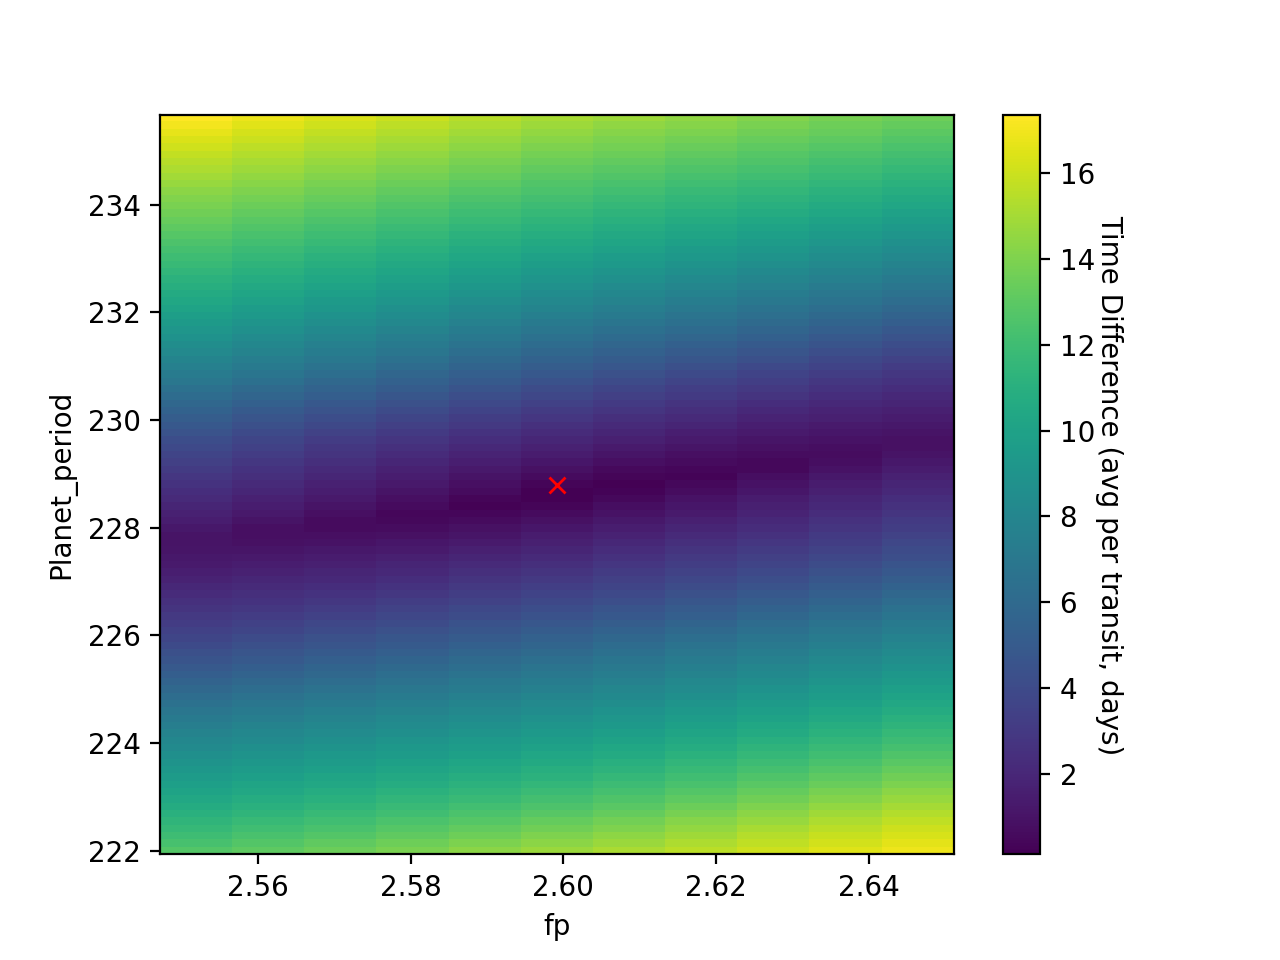

<IPython.core.display.Javascript object>


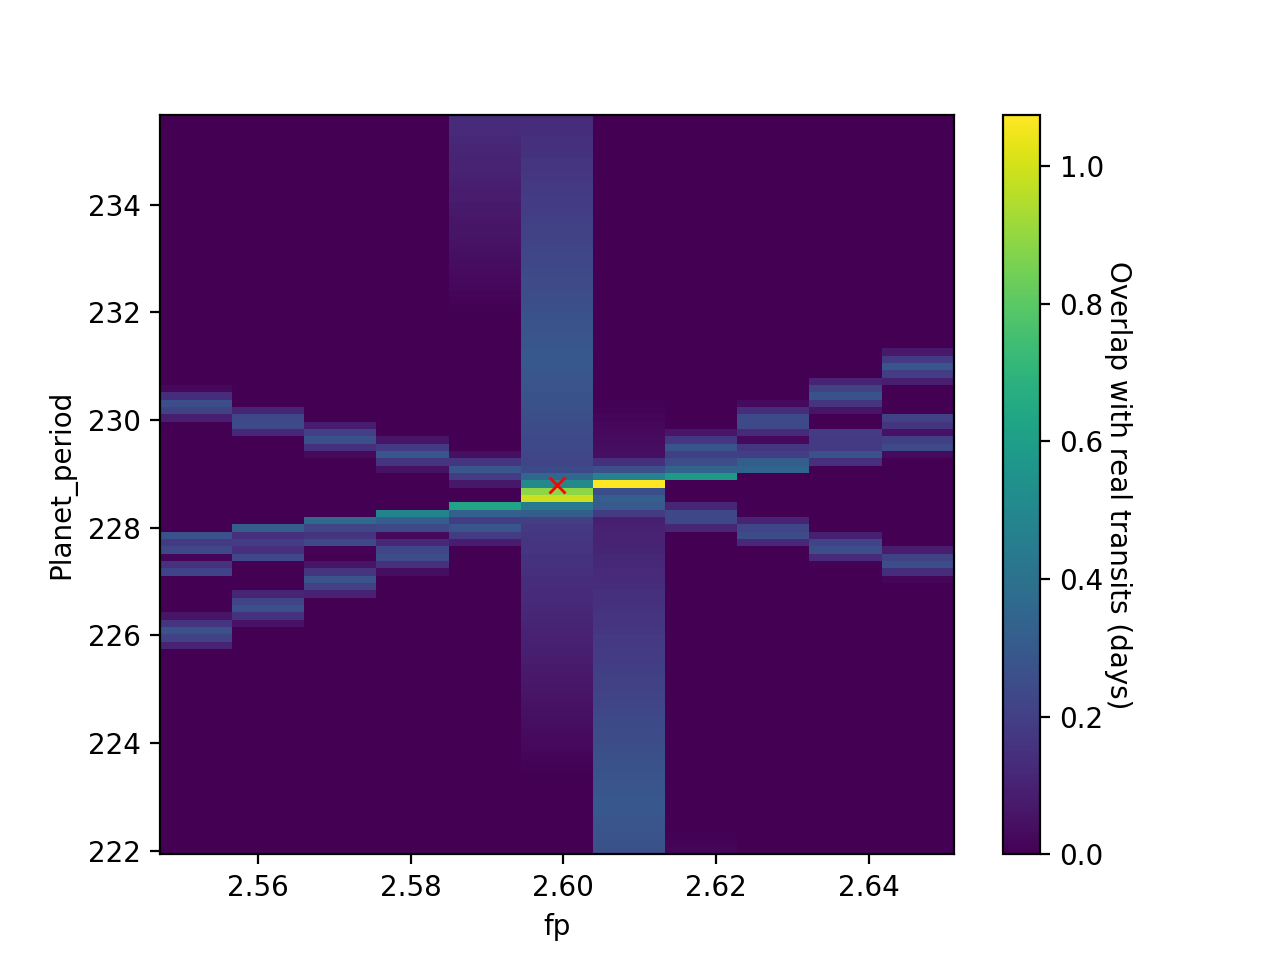

In [103]:
mratidx = 10
mtotidx = 2

#plots
p.figure()
palette = p.cm.viridis
p.imshow(timediffs[mratidx,mtotidx,:,:],origin='lower',
         extent=[np.min(fpset),np.max(fpset),np.min(ppset),np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Time Difference (avg per transit, days)', rotation=270, labelpad=10)
p.ylabel('Planet_period')
p.xlabel('fp')
p.plot(fp0,p_p0,'rx')

p.figure()
palette = p.cm.viridis
p.imshow(overlap[mratidx,mtotidx,:,:],origin='lower',
         extent=[np.min(fpset),np.max(fpset),np.min(ppset),np.max(ppset)],
         aspect='auto',cmap=palette)
cbar = p.colorbar()
cbar.set_label('Overlap with real transits (days)', rotation=270, labelpad=10)
p.ylabel('Planet_period')
p.xlabel('fp')
p.plot(fp0,p_p0,'rx')
